# $d^2N/dW_rdl$

In [1]:
from MgIIabs.model import halomodel as hmod
from MgIIabs.model import halomassfunc as hmf
from MgIIabs.model import dndwdl 
from scipy.integrate import quad, quadrature, fixed_quad, simps, romberg
import numpy as np
import astropy.units as u
from astropy.units.astrophys import M_sun, Mpc
from astropy.constants import G as grav
from compos import const
import matplotlib.pyplot as plt

import time
import cProfile

In [2]:
M = 1e12*Msun
rew = 0.1*u.nm
z = 0

H0 = 100*u.km/u.s/Mpc
rho_crit0 = (3*H0**2/(8*np.pi*grav)).to(Msun/Mpc**3)
const.initializecosmo(z=z)
rho_m = const.cosmo['omega_0']*rho_crit0*(1+z)**3

hmf.dNdM(M,z=z)*rho_m/M**2

<Quantity 3.8565719774002804e-15 1 / (Mpc3 solMass)>

In [3]:
integrand = lambda M: hmf.dNdM(M*1e12*Msun,z=z)*rho_m.value/(M**2*1e12)*np.pi*hmod.rg(M*1e12*Msun,z=z).value*hmod.p_rew_given_m(rew,M*1e12*Msun).value

In [4]:
integrand(1) #Units of 1/nm/M_sun/Mpc?

array([ 0.00372581])

In [38]:
rew = 0.1*u.nm
hmod.p_rew_given_m(rew,10**8.59*Msun)[0].value

4.4796329208511535e-07

In [5]:
start = time.time()
masses = np.linspace(10**8.584564/1e12,5,2**9+1)
integ = [integrand(m)[0] for m in masses]
stop = time.time()
stop-start

156.20450520515442

In [24]:
start = time.time()
x = quadrature(integrand,10**8.584564/1e12,5,vec_func=False,rtol=10**-6.5,miniter=100)
stop = time.time()
stop-start

63.864126682281494

In [23]:
x

(0.019424131626532819, 1.781794473285081e-07)

In [27]:
start = time.time()
x = quad(integrand,10**8.584564/1e12,5,epsrel=10**-6.5)
stop = time.time()
stop-start

/home/sunil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


331.42310190200806

In [28]:
x

(0.01942403186924131, 5.193874736553838e-07)

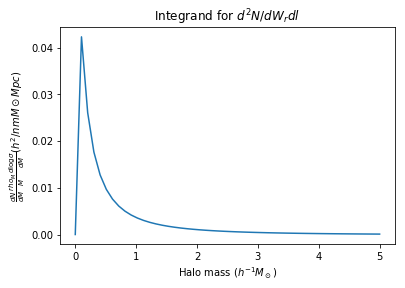

In [34]:
plt.plot(masses,integ)
plt.xlabel(r'Halo mass ($h^{-1} M_\odot$)')
plt.ylabel(r'$\frac{dN}{dM}\frac{rho_M}{M}\frac{d\log\sigma}{dM} (h^2/nm M\odot Mpc)$')
plt.title('Integrand for $d^2N/dW_rdl$')
plt.show()

It appears as if it is not necessary to consider halo masses below $10^{8.59}M_\odot$ (because they don't really produce 0.1 nm absorption) and above $10^{13}M_\odot$. For absorption stronger than 0.2 nm, you don't need halos beyond $10^{13}M_\odot$ and halos below $10^{10.65}M_\odot$. Maybe 13 is some sort of a robust cut-off for a large range of W. These lower limits can be found using the `lowest_mass` function in `halomodel`.

In [35]:
simps(x=masses,y=integ,)

0.017374814942287934

In [13]:
np.log10(hmod.lowest_mass(0.1*u.nm).value)

8.5845638630093273

# Integrating that integrand

In [2]:
start = time.time()
x = dndwdl.d2ndWdl(M_low=hmod.lowest_mass(0.1*u.nm).value/1e12,M_high=2)
stop = time.time()
stop-start

> /home/sunil/Python/MgIIabs/MgIIabs/model/dndwdl.py(43)d2ndWdl()
-> integral = quadrature(integrand,M_low,M_high)
(Pdb) c
> /home/sunil/Python/MgIIabs/MgIIabs/model/halomassfunc.py(181)dNdM()
-> sigma = np.sqrt(psvariance(R,z=z)[0])
(Pdb) M
array([  1.00019210e+12])
(Pdb) R
array([ 1.39635488])
(Pdb) c
> /home/sunil/Python/MgIIabs/MgIIabs/model/halomassfunc.py(79)psvariance()
-> integral = quad(integrand,low,high)
(Pdb) c
> /home/sunil/Python/MgIIabs/MgIIabs/model/halomassfunc.py(79)psvariance()
-> integral = quad(integrand,low,high)
(Pdb) c
> /home/sunil/Python/MgIIabs/MgIIabs/model/halomassfunc.py(79)psvariance()
-> integral = quad(integrand,low,high)
(Pdb) high
array([ 14.32300661])
(Pdb) c
> /home/sunil/Python/MgIIabs/MgIIabs/model/halomassfunc.py(181)dNdM()
-> sigma = np.sqrt(psvariance(R,z=z)[0])
(Pdb) R
array([ 1.04809009,  1.62536723])
(Pdb) M
array([  4.22952744e+11,   1.57743146e+12])
(Pdb) q


BdbQuit: 

In [6]:
x

(0.019424034210755205, 3.1608384208976746e-07)

In [13]:
hmod.lowest_mass(0.1*u.nm).value/1e12

0.0003842057524859883

In [20]:
integral = fixed_quad(integrand,a=0.0003842057524859883,b=5)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [17]:
help(quadrature)

Help on function quadrature in module scipy.integrate.quadrature:

quadrature(func, a, b, args=(), tol=1.49e-08, rtol=1.49e-08, maxiter=50, vec_func=True, miniter=1)
    Compute a definite integral using fixed-tolerance Gaussian quadrature.
    
    Integrate `func` from `a` to `b` using Gaussian quadrature
    with absolute tolerance `tol`.
    
    Parameters
    ----------
    func : function
        A Python function or method to integrate.
    a : float
        Lower limit of integration.
    b : float
        Upper limit of integration.
    args : tuple, optional
        Extra arguments to pass to function.
    tol, rtol : float, optional
        Iteration stops when error between last two iterates is less than
        `tol` OR the relative change is less than `rtol`.
    maxiter : int, optional
        Maximum order of Gaussian quadrature.
    vec_func : bool, optional
        True or False if func handles arrays as arguments (is
        a "vector" function). Default is True.
  

In [4]:
rew = 10**np.linspace(-1,3,10)*u.nm
start = time.time()
dnlist = [dndwdl.d2ndWdl(w) for w in rew]
stop=time.time()
stop-start

/home/sunil/anaconda3/lib/python3.5/site-packages/scipy/integrate/quadpack.py:364: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)


ValueError: rew=0.774264 nm cannot be achieved with this model

In [ ]:
dnlist = [item[0] for item in dnlist]

In [ ]:
plt.loglog(rew,dnlist)
plt.show()

In [4]:
dndwdl.d2ndWdl(0.5*u.nm)

> /home/sunil/Python/MgIIabs/MgIIabs/model/dndwdl.py(52)d2ndWdl()
-> return integral
(Pdb) M_low
51.58205684698422
(Pdb) M_high
10
--KeyboardInterrupt--
(Pdb) q


BdbQuit: 

In [5]:
integrand = lambda x:x**2
quad(integrand,0,-1)

(-0.33333333333333337, 3.700743415417189e-15)

In [ ]:
import